In [1]:
import h5py
import sys
import numpy as np
from scipy import io
from scipy.signal import hilbert as hilbert
from math import *;

import re
import glob
import os
import matplotlib.pyplot as plt
from matplotlib import image
import matplotlib.gridspec as gridspec
from matplotlib.backends.backend_pdf import PdfPages

import matplotlib.patches as patches
import matplotlib.ticker as mtick
import matplotlib.markers as markers

import pandas
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl

plt_attr={}
plt_attr["single"]=dict(color=(0,0,1), marker="o")
plt_attr["multi_1"]=dict(color=(0.9,0.1,0), marker="^")
plt_attr["multi_2"]=dict(color=(0.5,0.5,0), marker="s" )

plt_label={}
plt_label["single"]=dict(label="single")
plt_label["multi_1"]=dict(label="4mm" )
plt_label["multi_2"]=dict(label="8mm" )

def grnumaxis(nslc,flip=False):
    sqr=np.sqrt(nslc)
    if np.abs(np.mod( sqr, 1.0))<1e-16:
        #is perfect square
        nnc=int(sqr)
    else:
        nnc=floor(sqr)+1
    
    nnr = ceil(nslc/nnc)

    if flip:
        return (nnc,nnr)
    else:
        return (nnr,nnc)
    
def grax_ij(slidx, nnr,nnc):
    j_ax = np.mod(slidx,nnc)
    i_ax = floor(slidx/nnc)
    return (i_ax,j_ax)

def gray(f,container=list):
    if container==list:
        return [f,f,f]
    if container==np.array:
        return np.array([f,f,f])
    if container==tuple:
        return (f,f,f)

def vectorstr2arr(panda_vec_string,dtype=np.float):
    return np.array(list(map(float,panda_vec_string[1:-1].split())), dtype=dtype)

def vectorizeAndNormalize(string):
    x=vectorstr2arr(string)
    x*=1/1e12
    return x

def oneLogisticNotchFiltFunc(fx,f_lo,f_hi,scale):
    return 1.0 / (1 + np.exp(scale*(fx-f_lo)) ) + 1.0 / (1 + np.exp(-scale*(fx-f_hi)) )
    
def LogisticNotchFilter(fx,f0,window,nharm,harmstep=1.0, scale=200.0):
    """
    Recursive construction of filter. 
    Actual filter is [fn + window[0], fn + window[1]] around each step
    """

    fn = f0*nharm
    f_lo = fn+window[0]
    f_hi = fn+window[1]
    F = oneLogisticNotchFiltFunc(fx,f_lo, f_hi, scale)        
        
    if (nharm-harmstep)<=1e-9:
        #lowest recursion depth (fundamental or lowest subharmonic):
        return F
    else:    
        Fb = LogisticNotchFilter(fx, f0, window, nharm-harmstep, harmstep=harmstep, scale=scale)
    
    return Fb*F

def makename(case,power,probe,probestr=None):
    if probestr is None:
        probestr="probe%d"%probe
    
    return "%s/%s_%dW/%s"%(case,case,power,probestr)

def loadmaps( case,power, acqlist=None,h5f=None, timeavg=True):
    
        base=makename(case,power, 0)
    
        (nf,na,nz,nx)=h5f[base+'/cross'].shape
        Moment1Imgf=h5f[base+'/mom1'].value.reshape([2,nf*na,nz,nx])
        Moment2Imgf=h5f[base+'/mom2'].value.reshape([2,nf*na,nz,nx])
        ProbeCrossTerm = h5f[base+'/cross'].value.reshape([nf*na,nz,nx])
        
        if acqlist is None:
            varianceImage1 = Moment1Imgf[0]**2 - Moment2Imgf[0]
            varianceImage2 = Moment1Imgf[1]**2 - Moment2Imgf[1]
            coherenceTerm = 2*ProbeCrossTerm
        else:
            varianceImage1 = Moment1Imgf[0,acqlist]**2 - Moment2Imgf[0,acqlist]
            varianceImage2 = Moment1Imgf[1,acqlist]**2 - Moment2Imgf[1,acqlist]
            coherenceTerm = 2*ProbeCrossTerm[acqlist]
        if timeavg:
            varianceImage1 = np.mean(varianceImage1,axis=(0)) 
            varianceImage2 = np.mean(varianceImage2,axis=(0)) 
            coherenceTerm = np.mean(coherenceTerm,axis=(0)) 
            
        return (varianceImage1,varianceImage2,coherenceTerm)
    
    


In [2]:
def makeBoxPatch(x,q25,q75, width=1, **kwargs):
    p = patches.Rectangle( (x-width/2., q25), width, q75-q25, **kwargs )
    return p
    
def makeBoxPlotOne(axis, x,q10,q25,q50,q75,q90, width=1, plotkeys={},boxkeys={} ):
    p=makeBoxPatch(x,q25,q75,width=width, **boxkeys)
    
    axis.plot([x-width/2.0,x+width/2], [q50, q50], **plotkeys)
    axis.plot([x,x], [q10, q25], **plotkeys)
    axis.plot([x,x], [q75, q90], **plotkeys)
    axis.add_patch(p)
    return axis

def makeFullBoxPlot(axis, dataFrames,xadj=0, width=1, plotkeys={},boxkeys={}, xargs=None, matrix_input=False ):
    
    if matrix_input:
        q10=dataFrames[0]
        q25=dataFrames[1]
        q50=dataFrames[2]
        q75=dataFrames[3]
        q90=dataFrames[4]
        
        if xargs is None:
            raise ValueError('must supply xargs if matrix_input=True')
    else:
        if xargs is None:
            xargs = dataFrames[0].index 
        q10=dataFrames[0].data
        q25=dataFrames[1].data
        q50=dataFrames[2].data
        q75=dataFrames[3].data
        q90=dataFrames[4].data
    
    for powi in range(len(xargs)):
        makeBoxPlotOne(axis,xargs[powi] + xadj, q10[powi],q25[powi],q50[powi],q75[powi],q90[powi],width=width,plotkeys=plotkeys,boxkeys=boxkeys)
    return axis

In [3]:
phantfiles=["/Users/Vandiver/Data/Verasonics/sonalleve_20160709/CoupledRecon20160709.h5",
"/Users/Vandiver/Data/Verasonics/sonalleve_20160803/CoupledRecon_Phant_20160803.h5"]

chickenfiles=["/Users/Vandiver/Data/Verasonics/sonalleve_20160803/CoupledRecon_Chicken_20160803.h5"]
porkfiles=["/Users/Vandiver/Data/Verasonics/sonalleve_20160824/CoupledRecon_Pork_20160824.h5"]

In [4]:
f = h5py.File(porkfiles[0],'r')

In [387]:
f.close()

In [394]:
acqs=range(1,580)
power=40
(var1_s,var2_s,coh2_s) = loadmaps("single",power,acqlist=acqs,timeavg=False,h5f=f)
(var1_m1,var2_m1,coh2_m1) = loadmaps("multi_1",power,acqlist=acqs,timeavg=False,h5f=f)
(var1_m2,var2_m2,coh2_m2) = loadmaps("multi_2",power,acqlist=acqs,timeavg=False,h5f=f)

In [5]:
def mkimage(case,ti,probe=0):
    
    
    if case=="single":
        (im1,im2,coh)=(var1_s[ti], var2_s[ti],coh2_s[ti])
    elif case=="multi_1":
        (im1,im2,coh)=(var1_m1[ti], var2_m1[ti], coh2_m1[ti] )
    elif case=="multi_2":
        (im1,im2,coh)=(var1_m2[ti], var2_m2[ti], coh2_m2[ti] )
                       
    if probe==0:
        img=im1+im2+coh
    elif probe==1:
        img=im1
    elif probe==2:
        img=im2
    else:
        raise ValueError('Must use keyword probe = 0, 1, or 2')
        
    return np.sum(img,axis=0)/1e12

extent=f[makename("multi_2",80,1)+"/map"].attrs['extent']

In [310]:
img1=mkimage("single", integrate, probe=0)

In [399]:
integrate=range(0,579)


In [313]:
extent

array([-1.91,  1.91,  8.98,  4.  ])

In [320]:
ext

array([-1.91 ,  1.91 , -8.844, -3.864])

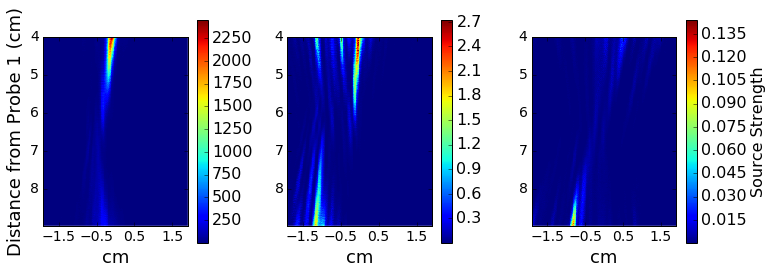

In [400]:
fig=plt.figure(figsize=(12,4))
pr=0
img1=mkimage("single", integrate,probe=pr)
img2=mkimage("multi_1", integrate,probe=pr)
img3=mkimage("multi_2", integrate,probe=pr)
ext=extent.copy()

ylabel='Distance from Probe 1 (cm)'
if pr==2:
    flip=lambda img: np.fliplr(np.flipud(img))
    flip=lambda img: np.flipud(img)
    ext[3] = 13.6 - extent[2]
    ext[2] = 13.6 - extent[3]
    img1=flip(img1)
    img2=flip(img2)
    img3=flip(img3)
    ylabel='Distance from Probe 2 (cm)'


gsPow=gridspec.GridSpec(1,3,wspace=0.35,hspace=0.25)

ax1=fig.add_subplot(gsPow[0,0])
vmax=np.percentile(img1,100)
im1=ax1.imshow( img1, extent=ext,interpolation='None')
cb1 = plt.colorbar(mappable=im1)

ax2=fig.add_subplot(gsPow[0,1])
im2=ax2.imshow( img2, extent=ext,interpolation='None')
cb2 = plt.colorbar(mappable=im2)
#ax2.set_ylabel('cm',fontsize=18)

ax3=fig.add_subplot(gsPow[0,2])
im3=ax3.imshow( img3, extent=ext,interpolation='None')
cb3 = plt.colorbar(mappable=im3)


ax1.set_ylabel(ylabel,fontsize=18)

cb3.set_label('Source Strength',fontsize=16)
for cb in (cb1,cb2,cb3):
    #cb.set_label('Source Strength',fontsize=16)
    cb.ax.tick_params(labelsize=16)
    
xlocls=np.arange(-1.5,1.51, 1.0)
for ax in (ax1,ax2,ax3):
    ax.tick_params(labelsize=14)
    ax.set_xticks(xlocls)
    ax.set_xlabel('cm',fontsize=18)
    


In [350]:
fig.savefig("/Users/Vandiver/OneDrive/Documents/Multi-foc Paper/80W_phant_both_all.png")

In [1035]:
np.mean(img)

75.663885877970912

In [1028]:
imageLevelDF.query("case=='%s'"%("multi_1")).query("power==60").query("material=='phantom'")['imgmag']/1e12

10    34.231193
28    28.622351
Name: imgmag, dtype: float64

In [188]:


(varianceImage1,varianceImage2,coherenceTerm) = loadmaps("multi_2",40,acqlist=range(1,41),timeavg=False,h5f=f)
extent=f[makename("multi_2",60,1)+"/map"].attrs['extent']

#varVsPower[ci,pi]=np.sum(varianceImage1+varianceImage2)/2
#cohVsPower[ci,pi]=np.sum(np.abs(coherenceTerm))
#coupledMagVsPower[ci,pi]=np.sum(coherenceTerm) + varVsPower[ci,pi]

coherenceVsTime=np.mean(coherenceTerm,axis=(1,2))
imgMagVsTime=np.mean(varianceImage1+varianceImage2,axis=(1,2)) + coherenceVsTime
imgMag=np.sum(imgMagVsTime)

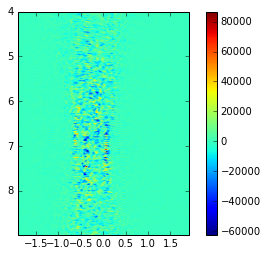

In [190]:
plt.imshow( np.mean(coherenceTerm,axis=0),extent=extent)
plt.colorbar()

## Compute Cavitaiton Levels

In [72]:
calcData=[]

In [71]:
f.close()

In [1217]:
datasets=phantfiles
material="phantom"

In [88]:
powers=[5,10,20,40,60,80]
cases=["single", "multi_1", "multi_2"]

acqlist=range(1,580)



#imageSets = np.zeros([len(cases),len(powers)] )

for h5file in datasets:
    
    f = h5py.File(h5file,'r')
    
    datafile_basename=os.path.basename(h5file)
    datafile_basename

    datesrch=re.search('(\d{8})', datafile_basename)
    if datesrch:
        datestr=datesrch.group(1)
    else:
        datestr=''

    for ci in range(0,len(cases)):
        case=cases[ci]
        for pi in range(len(powers)):

            base=makename(case,powers[pi], 0)
            print(base,flush=True)
            (varianceImage1,varianceImage2,coherenceTerm) = loadmaps(case,powers[pi],acqlist=acqlist,timeavg=False,h5f=f)

            #varVsPower[ci,pi]=np.sum(varianceImage1+varianceImage2)/2
            #cohVsPower[ci,pi]=np.sum(np.abs(coherenceTerm))
            #coupledMagVsPower[ci,pi]=np.sum(coherenceTerm) + varVsPower[ci,pi]

            coherenceVsTime=np.mean(coherenceTerm,axis=(1,2))
            imgMagVsTime=np.mean(varianceImage1+varianceImage2,axis=(1,2)) + coherenceVsTime
            imgMag=np.sum(imgMagVsTime)
            
            
            calcData.append( dict(date=datestr,case=case,power=powers[pi],material=material,imgmag=imgMag,curve=imgMagVsTime,cohcurve=coherenceVsTime))
            
    f.close()

single/single_5W/probe0
single/single_10W/probe0
single/single_20W/probe0
single/single_40W/probe0
single/single_60W/probe0
single/single_80W/probe0
multi_1/multi_1_5W/probe0
multi_1/multi_1_10W/probe0
multi_1/multi_1_20W/probe0
multi_1/multi_1_40W/probe0
multi_1/multi_1_60W/probe0
multi_1/multi_1_80W/probe0
multi_2/multi_2_5W/probe0
multi_2/multi_2_10W/probe0
multi_2/multi_2_20W/probe0
multi_2/multi_2_40W/probe0
multi_2/multi_2_60W/probe0
multi_2/multi_2_80W/probe0


#### Compute spectral indices ###

In [1232]:
specData=[]

In [1233]:

sets=[phantfiles,chickenfiles,porkfiles]
materials=["phantom","chicken", "pork"]


for si in range(len(sets)):
    datasets=sets[si]
    material=materials[si]
    for h5file in datasets:

        f = h5py.File(h5file,'r')

        datafile_basename=os.path.basename(h5file)
        datafile_basename

        datesrch=re.search('(\d{8})', datafile_basename)
        if datesrch:
            datestr=datesrch.group(1)
        else:
            datestr=''

        for ci in range(0,len(cases)):
            case=cases[ci]
            for pi in range(len(powers)):

                CavIndex=0
                BB=0
                HH=0
                BBcurve=0
                HHcurve=0
                timeSeriesVariance=0
                for probe in [1,2]:
                    extstr=makename(case,powers[pi], probe)
                    #print(extstr,flush=True)

                    ovflw=f[extstr+"/var/tot"].attrs["overflows"]
                    chsumSpecVsAcq = f[extstr+"/var/sumspec"]
                    timeSeriesVariance+=np.sum( f[extstr+"/var/tot"].value, axis=0)

                    endidx=chsumSpecVsAcq.attrs["endidx"]
                    harmonicFilter=chsumSpecVsAcq.attrs["filter"][0:endidx]

                    BB += np.mean(np.sum( chsumSpecVsAcq[acqlist]*harmonicFilter,axis=1 ))
                    HH += np.mean(np.sum( chsumSpecVsAcq[acqlist]*(1-harmonicFilter),axis=1 ))

                    CavIndex += np.mean(np.sum(np.log10( chsumSpecVsAcq[acqlist] ) ,axis=1))

                    BBcurve+=np.sum( chsumSpecVsAcq[acqlist]*harmonicFilter,axis=1 )
                    HHcurve+=np.sum( chsumSpecVsAcq[acqlist]*(1-harmonicFilter),axis=1 )


                specData.append( dict(date=datestr,case=case,power=powers[pi],material=material,
                                      Variance=timeSeriesVariance, BBcurve=BBcurve,HHcurve=HHcurve,BB=BB,HH=HH,cavidx=CavIndex,acqs=acqlist))

        f.close()

In [202]:
len(acqlist)

NameError: name 'acqlist' is not defined

In [1235]:
len(specData)

72

In [1236]:
imageLevelDF=pandas.DataFrame(calcData)
specinfoDF=pandas.DataFrame(specData)

#### Compute Quantiles of image magniutde ###

In [203]:
quantiles=[0,5,25,50,75,95,100]

imageLevelQuantiles=[]

for rowi in range(len(imageLevelDF)):
    
    row=imageLevelDF.iloc[rowi]

    curve = vectorizeAndNormalize(row['curve'])
    
    numtimes= len(curve)
    
    cavpnt= np.percentile(curve, quantiles)
    cavStdDev=np.std(curve)
    cavMean=np.mean(curve)
    
    trial=dict(std=cavStdDev, mean=cavMean, nt=numtimes)
    for qi in range(len(quantiles)):
        qstr="Q%d"%quantiles[qi]
        trial[qstr] = cavpnt[qi]
    imageLevelQuantiles.append(trial)

imageLevelQuantiles=pandas.DataFrame(imageLevelQuantiles)

In [204]:
#merge results
imageLevelDF = pandas.concat([imageLevelDF, imageLevelQuantiles], axis=1, join_axes=[imageLevelDF.index])

In [206]:
imageLevelDF.to_csv("/Users/Vandiver/Data/Verasonics/MulitfocusCav/CoupledImageMagData_All.csv")

In [1506]:
specinfoDF.to_csv("/Users/Vandiver/Data/Verasonics/MulitfocusCav/CoupledSepcInfoData_All.csv")

In [691]:
len(vectorstr2arr(pgrouped.nth(0).iloc[5].curve))

20

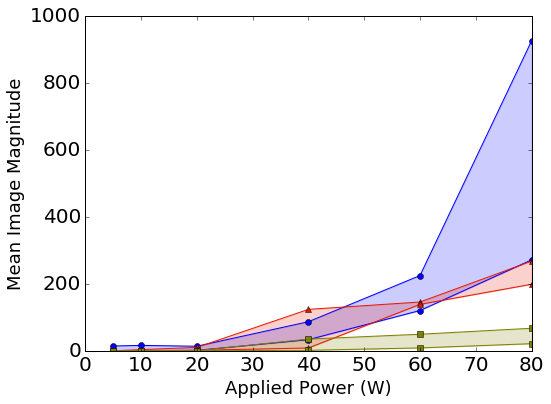

In [1249]:
fig=plt.figure(figsize=(8,6))
for case in cases:

    pgrouped=imageLevelDF.query("material=='phantom'").query("case=='%s'"%(case)).sort_values(by='power').groupby('power')


    imgmax=pgrouped.aggregate(dict(imgmag=np.max)) /1e12
    imgmin=pgrouped.aggregate(dict(imgmag=np.min)) /1e12

    plt.plot(imgmax, color=plt_attr[case]['color'], marker=plt_attr[case]['marker'])
    plt.plot(imgmin, color=plt_attr[case]['color'], marker=plt_attr[case]['marker'])
    plt.fill_between(imgmin.index,imgmin.imgmag,y2=imgmax.imgmag,alpha=0.2, color=plt_attr[case]['color'], step=None) 
    
plt.xlabel('Applied Power (W)',fontsize=18)
plt.ylabel('Mean Image Magnitude',fontsize=18)
plt.gca().tick_params(labelsize=20)
#plt.yscale('log')

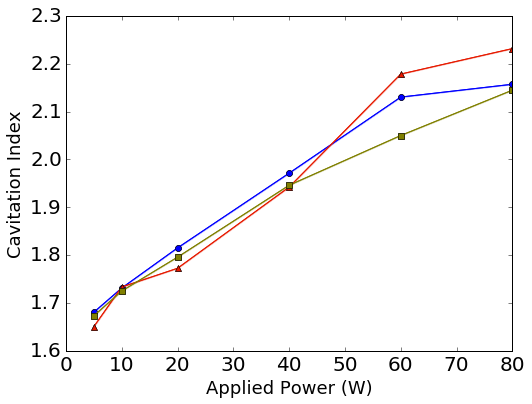

In [126]:
fig2=plt.figure(figsize=(8,6))

plt.xlabel('Applied Power (W)',fontsize=18)
plt.ylabel('Cavitation Index',fontsize=18)
plt.gca().tick_params(labelsize=20)
for case in cases:

    pgrouped=specinfoDF.query("material=='chicken'").query("case=='%s'"%(case)).sort_values(by='power').groupby('power')


    cavmax=pgrouped.aggregate(dict(cavidx=np.max)) / 1e4
    cavmin=pgrouped.aggregate(dict(cavidx=np.min)) / 1e4

    plt.plot(cavmax, color=plt_attr[case]['color'], marker=plt_attr[case]['marker'])
    plt.plot(cavmin, color=plt_attr[case]['color'], marker=plt_attr[case]['marker'])
    plt.fill_between(cavmin.index,cavmin.cavidx, y2=cavmax.cavidx,alpha=0.2, color=plt_attr[case]['color'], step=None) 
    


### Box plot- Cavitation vs Power

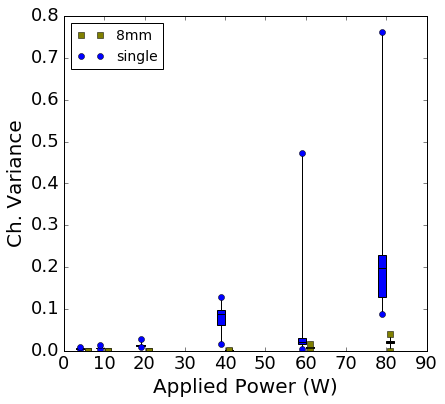

In [276]:
#groupdCavRes = imageLevelDF.query("material=='pork'").query("case!='multi_1'").groupby(['case','material'])

groupdCavRes = specinfoDF.query("material=='pork'").query("case!='multi_1'").groupby(['case','material'])

#computed = grouped['finalT'].agg([np.min, np.max])

caseXadj=dict(single=-2.5,multi_1=0,multi_2=2.5)
Xadj=dict(phantom=caseXadj, pork=dict(single=-1.,multi_2=1.), chicken=caseXadj)

fig=plt.figure(figsize=(6.5,6))
quantiles=[0,5,25,50,75,95,100]

ax=fig.gca()

for gidx,rowids in groupdCavRes:
    
    case=gidx[0]
    material=gidx[1]
    g=groupdCavRes.get_group(gidx).groupby('power')
    
    caseXadj=Xadj[material]
    
    statHolder=[]
    for powval, powTrialRows in g:
        #combine all time points from the technical replicates to get distribution
        curve_tech_replicates = (1e12/1e9)*np.concatenate( tuple(map(lambda x: vectorizeAndNormalize(x)[1:], powTrialRows['Variance'].as_matrix() )) )
        
        cavpnt= np.percentile(curve_tech_replicates, quantiles)
        cavStdDev=np.std(curve_tech_replicates)
        cavMean=np.mean(curve_tech_replicates)
        
        power_replicate_set=dict(power=powval,std=cavStdDev, mean=cavMean)
        for qi in range(len(quantiles)):
            qstr="Q%d"%quantiles[qi]
            power_replicate_set[qstr] = cavpnt[qi]
        
        statHolder.append(power_replicate_set)
        
    statHolder=pandas.DataFrame(statHolder)
    
    makeFullBoxPlot(ax, statHolder[['Q0','Q25','Q50','Q75','Q100']].as_matrix().transpose(), matrix_input=True,
                xadj=caseXadj[case],width=2.0, xargs=statHolder['power'],
               plotkeys=dict(color='k'), boxkeys=dict(edgecolor='k',facecolor=plt_attr[case]['color']))

    ax.plot(statHolder['power']+ caseXadj[case], statHolder['Q0'], '.', label='_nolegend_', **plt_attr[case])
    ax.plot(statHolder['power']+ caseXadj[case], statHolder['Q100'], '.', label=plt_label[case]['label'], **plt_attr[case])
    #ax.plot(statHolder['power']+ caseXadj[case], statHolder['Q100'], '.', label='_nolegend_', **plt_attr[case])

#ax.set_yscale('log') 


ax.set_xlabel('Applied Power (W)',fontsize=20)
ax.set_ylabel('Ch. Variance',fontsize=20)
ax.tick_params(labelsize=18)
plt.legend(fontsize=14,loc=2)

#ax.set_xlim([0, ax.get_xlim()[1]])

In [277]:
odir="/Users/Vandiver/OneDrive/Documents\Multi-foc Paper/"
nameend="VsPower_Pork_All.png"

#fig2.savefig(odir+"CavIdx"+nameend)
#plt.close(fig2)

fig.savefig(odir+"Variance"+nameend)    
plt.close(fig)



In [30]:
imageLevelDF= pandas.read_csv("/Users/Vandiver/Data/Verasonics/MulitfocusCav/CoupledImageMagData_All.csv")
specinfoDF = pandas.read_csv("/Users/Vandiver/Data/Verasonics/MulitfocusCav/CoupledSepcInfoData_All.csv")

In [257]:
imageLevelDF= pandas.read_csv("/Users/Vandiver/Data/Verasonics/MulitfocusCav/CoupledImageMagData_20.csv")
specinfoDF = pandas.read_csv("/Users/Vandiver/Data/Verasonics/MulitfocusCav/CoupledSepcInfoData_20.csv")

In [5]:
specinfoDF.query("case=='%s'"%("multi_2")).query("power==60")

,Unnamed: 0,Unnamed: 0.1,BB,BBcurve,HH,HHcurve,Variance,acqs,case,cavidx,date,material,power
17,17,17,5.481312e+09,[ 1.06641141e+10 1.01875026e+10 9.7753845...,3.392706e+09,[ 6.37670282e+09 6.19460702e+09 6.0229299...,[ 1.14660458e+08 2.59028773e+08 2.4056915...,"range(1, 580)",multi_2,23981.048828,20160709,phantom,60
35,35,35,8.616997e+09,[ 1.23228427e+10 1.23878470e+10 1.2993462...,5.015958e+09,[ 7.15345531e+09 7.02046206e+09 7.4431589...,[ 4.83919619e+08 3.34233387e+08 3.2844885...,"range(1, 580)",multi_2,24740.833008,20160803,phantom,60
53,53,53,3.417993e+08,[ 3.64522150e+08 2.91411225e+08 3.6548653...,8.694699e+08,[ 9.39451961e+08 7.39893512e+08 9.2755234...,[ 3.72384455e+07 2.06942889e+07 1.2172766...,"range(1, 580)",multi_2,20417.751953,20160803,chicken,60
71,71,71,4.285656e+08,[ 8.12607778e+08 5.99909328e+08 4.5035637...,7.230205e+08,[ 1.33510139e+09 1.00605007e+09 8.0468099...,[ 7.33245824e+05 1.63075021e+07 1.2329995...,"range(1, 580)",multi_2,20657.079102,20160824,pork,60


In [213]:
xb=579

scalepoints=np.arange(1,xb,10)
scv=1-np.exp(-4*(scalepoints-1.0)/xb)
scv[0]=0
scv[-1]=1

maptuples=list(map(lambda i: (i/ (len(scalepoints)-1), tuple((1-scv[i])*np.array(np.array([0,0,0])) + (scv[i])*np.array([1,1,1]) ) ), 
                   range(len(scalepoints)) ))
mycm=LinearSegmentedColormap.from_list('mylist', maptuples)

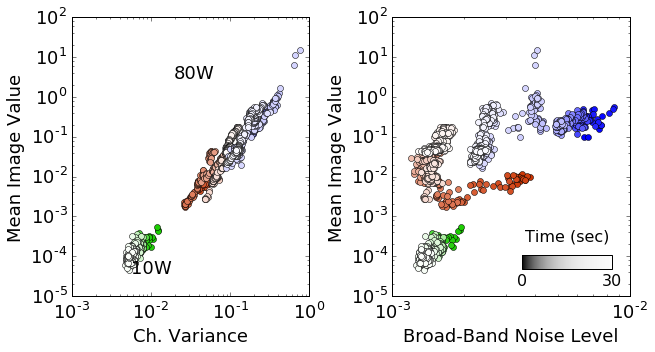

In [226]:
thisColor={}
thisColor[10]=dict(color=(.1,.8,0))
thisColor[20]=dict(color=(1.0, .6,0.6))
thisColor[40]=dict(color=(0.8, .2,0))
thisColor[80]=dict(color=(0,0,1))

material="pork"

fig=plt.figure(figsize=(10,5))
gsPow=gridspec.GridSpec(1,2,wspace=0.35,hspace=0.25)

axes=[]
for j in range(0,2):
    axes.append(fig.add_subplot(gsPow[0,j]))
    

for case in ["single"]:
    for power in [10,40,80]:
        set1=imageLevelDF.query("case=='%s'"%(case)).query("power==%d"%power).query("material=='%s'"%material)
        set2=specinfoDF.query("case=='%s'"%(case)).query("power==%d"%power).query("material=='%s'"%material)
        avgmag=np.mean(set1['imgmag'])
        
        magCurve=vectorstr2arr(set1['curve'].iloc[0]) /1e12
        bbCurve=(vectorstr2arr( set2['BBcurve'].iloc[0] ) /1e12)
        varCurve=vectorstr2arr( set2['Variance'].iloc[0] )[1:] /1e9
        for ti in range(1,xb):
            u=np.exp(-4*(ti-1.0)/xb)
            color= u*np.array(thisColor[power]["color"]) + (1-u)*np.array([1,1,1])
            axes[0].plot(varCurve[ti],magCurve[ti],'o', alpha=1, color=color)
            axes[1].plot(bbCurve[ti],magCurve[ti],'o', alpha=1,color=color)
        #plt.plot(varCurve[0:29],magCurve[0:29],'o',color='g')

for j in range(0,2):
    axes[j].set_xscale('log')
    axes[j].set_yscale('log')
    axes[j].set_ylabel('Mean Image Value', fontsize=18)
    axes[j].tick_params(labelsize=18)
axes[0].set_xlabel('Ch. Variance', fontsize=18)
axes[1].set_xlabel('Broad-Band Noise Level', fontsize=18)
axes[0].text(0.25, 0.1,'10W', horizontalalignment='left',verticalalignment='center', 
             transform=axes[0].transAxes,fontsize=18)
axes[0].text(0.6, 0.8,'80W', horizontalalignment='right',verticalalignment='center', 
             transform=axes[0].transAxes,fontsize=18)


tickp=np.arange(0,xb,200)
tickp=np.array([0,600])
tickstr = list(map(lambda s:"%0.f" % s,tickp*(50e-3) + 0))

ax=fig.add_axes([0.75, 0.2, 0.125, 0.04])

sc=mpl.cm.ScalarMappable(cmap=mycm)
sc.set_array(scalevalues)
cb=plt.colorbar(mappable=sc,orientation='horizontal',cax=ax)
cb.set_cmap(mycm)
cb.set_ticks(tickp/(600+1))
cb.set_ticklabels(tickstr)  
cb.set_label('Time (sec)',fontsize=16,labelpad=-60)
cb.ax.tick_params(labelsize=16)

In [178]:
xb

579

In [223]:
bbCurve.shape

(578,)

In [225]:
fig.savefig("/Users/Vandiver/OneDrive/Documents/Multi-foc Paper/ImageMagCorrelates_Phant2.png")
plt.close(fig)

In [234]:
case="single"
material="phantom"
power=10
set1=imageLevelDF.query("case=='%s'"%(case)).query("power==%d"%power).query("material=='%s'"%material)
set2=specinfoDF.query("case=='%s'"%(case)).query("power==%d"%power).query("material=='%s'"%material)

        
magCurve=vectorstr2arr(set1['curve'].iloc[0]) /1e12
bbCurve=(vectorstr2arr( set2['BBcurve'].iloc[0] ) /1e12)
varCurve=vectorstr2arr( set2['Variance'].iloc[0] )[1:] /1e9

In [232]:
varCurve.shape

(580,)

In [235]:
np.corrcoef([varCurve, magCurve])

array([[ 1.        ,  0.92821012],
       [ 0.92821012,  1.        ]])

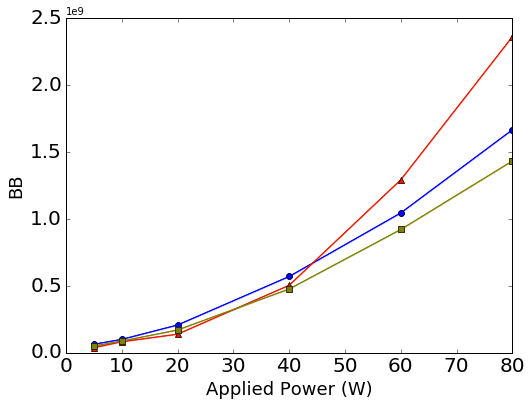

In [137]:
fig3=plt.figure(figsize=(8,6))

plt.xlabel('Applied Power (W)',fontsize=18)
plt.ylabel('BB',fontsize=18)
plt.gca().tick_params(labelsize=20)
for case in cases:

    pgrouped=specinfoDF.query("material=='chicken'").query("case=='%s'"%(case)).sort_values(by='power').groupby('power')


    bbmax=pgrouped.aggregate(dict(BB=np.max,HH=np.max)) 
    bbmin=pgrouped.aggregate(dict(BB=np.min,HH=np.min))
    X=bbmax.index
    Y1=bbmin.HH 
    Y2=bbmax.HH 

    plt.plot(X,Y1, color=plt_attr[case]['color'], marker=plt_attr[case]['marker'])
    plt.plot(X,Y2, color=plt_attr[case]['color'], marker=plt_attr[case]['marker'])
    plt.fill_between(X,Y1, y2=Y2,alpha=0.2, color=plt_attr[case]['color'], step=None) 
    


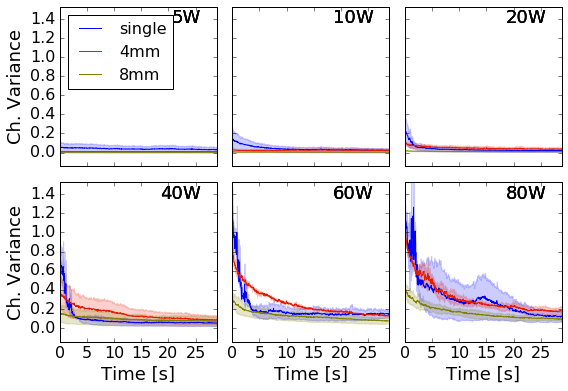

In [37]:
powers=[5,10,20,40,60,80]
#powers=[10,40,80]
(nnr,nnc) = grnumaxis(len(powers),flip=False)
#(nnr,nnc)=(1,3)
gsPows=gridspec.GridSpec( nnr, nnc, wspace=0.1,hspace=0.1)

cases=["single","multi_1", "multi_2"]


figP=plt.figure(figsize=(9,6))
#figP=plt.figure(figsize=(10,3.3))

ax2s=[]
for pwi in range(len(powers)):
    (ii,jj) = grax_ij(pwi,nnr,nnc)
    ax2s.append( figP.add_subplot(gsPows[ii, jj])  )
    
material="phantom"
aidx=range(1,579)
xlabelpos = np.arange(0,aidx[-1]+2, 100)
times = xlabelpos*50e-3
rowmax=np.zeros([nnr])
for case in ["single", "multi_1", "multi_2"]:
    for pwi in range(len(powers)):
        power = powers[pwi]
        set1=imageLevelDF.query("case=='%s'"%(case)).query("power==%d"%power).query("material=='%s'"%material)
        set2=specinfoDF.query("case=='%s'"%(case)).query("power==%d"%power).query("material=='%s'"%material)
        avgmag=np.mean(set1['imgmag'])
        
        ii,jj = grax_ij(pwi,nnr,nnc)
        
        #magCurve=vectorstr2arr(set1['curve'].iloc[0]) /1e12
        #magCurve=vectorstr2arr(set2['Variance'].iloc[0]) /1e9
        #magCurve=(vectorstr2arr(set2['Variance'].iloc[0] )[aidx] + vectorstr2arr(set2['Variance'].iloc[1] )[aidx])*1e-9/2
        
        curve_set_w_replicates = np.array(list(map(lambda x: vectorstr2arr(x)[aidx], set2['Variance'])))/1e9
        magCurve = np.mean(curve_set_w_replicates,axis=0)
        errbars =np.std(curve_set_w_replicates,axis=0) /2
        minCurve=np.min(curve_set_w_replicates,axis=0)
        maxCurve=np.max(curve_set_w_replicates,axis=0)
        #bbCurve=(vectorstr2arr( set2['BBcurve'].iloc[1] )/1e12 )
        
        ax2s[pwi].plot(magCurve, label=plt_label[case]['label'],markersize=0,markeredgecolor=plt_attr[case]['color'],  **plt_attr[case])
        
        
        #ax2s[pwi].errorbar(range(0,len(aidx)), magCurve, yerr=errbars, label=plt_label[case]['label'],
        #                   markersize=0,markeredgecolor=plt_attr[case]['color'], **plt_attr[case])
        
        ax2s[pwi].fill_between(range(0,len(aidx)), minCurve, y2=maxCurve, alpha=0.2, color=plt_attr[case]['color'], step=None) 
        
        ax2s[pwi].text(0.9,0.9,'%dW'%power, transform=ax2s[pwi].transAxes, horizontalalignment='right', fontsize=18,color='k')

        ax2s[pwi].set_xlabel('Time [s]', fontsize=18)
        ax2s[pwi].set_ylabel('Ch. Variance', fontsize=18)
        
        if np.max(magCurve) > rowmax[ii]:
            rowmax[ii]=np.max(magCurve)
        if jj != 0:
            #ax2s[pax].axes.yaxis.set_ticks([])
            ax2s[pwi].axes.yaxis.set_ticklabels([])
            ax2s[pwi].set_ylabel('')
        if ii==(nnr-1):
            ax2s[pwi].set_xticklabels(list(map( lambda x: "%d"%x,times) ) )
            ax2s[pwi].set_xticks(xlabelpos)
        else:
            ax2s[pwi].axes.xaxis.set_ticklabels([])
            ax2s[pwi].set_xticks(xlabelpos)
            ax2s[pwi].set_xlabel('')
            
for pwi in range(len(powers)):
    ii,jj = grax_ij(pwi,nnr,nnc)
    ax2s[pwi].set_ylim([-rowmax[-1]/10, rowmax[-1]*1.05])
    ax2s[pwi].tick_params(labelsize=16)
    #ax2s[pwi].set_yscale('log')
ax2s[0].legend(loc=2,fontsize=16)

In [11]:
curve_set_w_replicates = np.array(list(map(lambda x: vectorstr2arr(x)[aidx], set2['Variance'])))/1e9

In [20]:
ax.fill_between

In [39]:
figP.savefig("/Users/Vandiver/OneDrive/Documents/Multi-foc Paper/VarianceHistory_PhantomAllRange.eps")

### Load MR Results

In [32]:
mrisets = [ 
    dict(use=1, path='/Users/Vandiver/Data/Verasonics/sonalleve_20160709/',
            pars='HifuScanParameters.csv', temp='scans_batch_DT_unwr_20160709.csv'),
    dict(use=1, path='/Users/Vandiver/Data/sonalleve/HifuCav20160810/',
            pars='HifuScanParams.csv', temp='scans_batch_DT_unwr_20160810.csv')]
            
tempfile='/Users/Vandiver/Data/Verasonics/cav_scans_batch_DT_unwr2.csv'

merged_frames=[]
for mi in range(len(mrisets)):
    
    if not mrisets[mi]['use']:
        continue
    
    parsfile=mrisets[mi]['path']+mrisets[mi]['pars']
    scanHifuParams = pandas.read_csv(parsfile)
            
    #tempfile=mrisets[mi]['path']+mrisets[mi]['temp']
    scanAnalysisDT = pandas.read_csv(tempfile)
    
    
    merged = scanAnalysisDT.merge(scanHifuParams)
    merged_frames.append(merged)
    
merged = pandas.concat(merged_frames)

peakT=np.zeros([len(merged)])
percentiles = [0,5,10,25, 50,75, 90, 95,99, 100]

quant=np.zeros([len(percentiles),len(merged)])
stdT=np.zeros_like(peakT)
nMildRange=np.zeros_like(peakT)
nnVox=np.zeros_like(peakT)
for i in range(len(merged)):
    roiMaxTemps = vectorstr2arr(merged.maxTdata.iloc[i])
    peakT[i] = np.max(vectorstr2arr(merged.maxTdata.iloc[i]))
    
    stdT[i] = np.std(roiMaxTemps)
    quantiles = np.percentile( roiMaxTemps, percentiles )
    for qi in range(len(quantiles)):
        quant[qi,i]=quantiles[qi]
        
    nMildRange[i]=np.sum( np.logical_and( roiMaxTemps>=3.0, roiMaxTemps<=8.0))
    nnVox[i]=len(roiMaxTemps)
merged['stdT'] = stdT
merged['peakT'] = peakT
merged['mild']=nMildRange
merged['nvox']=nnVox
merged['mildfrac']=nMildRange/nnVox
for qi in range(len(percentiles)):
    qstr="Q%d"%percentiles[qi]
    merged[qstr] = quant[qi,:]


In [132]:
merged.query("material=='pork'").query("power==40")[['file','roi']]

,file,roi
15,scan29_TempSag_20160810.PAR,[76 85 77 86 1 7]
18,scan37_TempSag_20160810.PAR,[74 83 77 86 1 7]


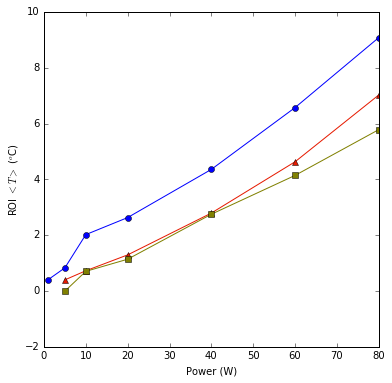

In [5]:
grouped = merged.query("material=='phantom'").groupby(['tag','material'])
#computed = grouped['finalT'].agg([np.min, np.max])

fig=plt.figure(figsize=(6,6))

for gidx,rowids in grouped:
    
    case=gidx[0]
    g=grouped.get_group(gidx).groupby('power')
    
    powers = list(g.groups.keys())  
    
    avgTr = g['finalT'].agg([np.min, np.max, np.mean])
    #numr = g['n5'].agg([np.min, np.max])
    #n10r = g['n10'].agg([np.min, np.max])
    #n15r = g['n15'].agg([np.min, np.max])

    plt.plot(avgTr.index, avgTr['mean'], 'o-',**plt_attr[case])
    plt.xlabel('Power (W)')
    plt.ylabel('ROI $<T>$ ($^o$C)')

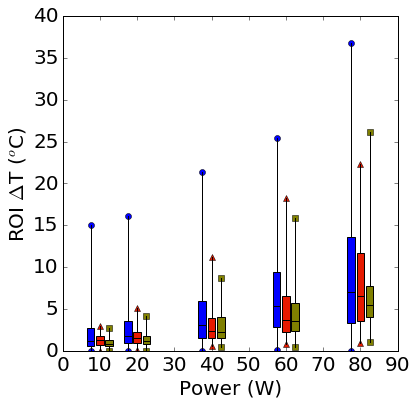

In [87]:
grouped = merged.query("material=='phantom'").query("power>=10").query("date!='x2016-07-09'").groupby(['tag','material'])
#computed = grouped['finalT'].agg([np.min, np.max])

fig=plt.figure(figsize=(6,6))

caseXadj=dict(single=-2.5,multi_1=0,multi_2=2.5)

Xadj=dict(phantom=caseXadj, pork=dict(single=-1.,multi_2=1.), chicken=caseXadj)

ax = fig.gca()
for gidx,rowids in grouped:
    
    case=gidx[0]
    material=gidx[1]
    g=grouped.get_group(gidx).groupby('power')
    
    powers = list(g.groups.keys())  
    
    avgTr = g['finalT'].agg([np.min, np.max, np.mean])
    peakTr = g['peakT'].agg([np.min, np.max, np.mean])
    
    q0=g['Q0'].agg([np.min, np.max, np.mean])
    q25=g['Q25'].agg([np.min, np.max, np.mean])
    q50=g['Q50'].agg([np.min, np.max, np.mean])
    q75=g['Q75'].agg([np.min, np.max, np.mean])
    q100=g['Q99'].agg([np.min, np.max, np.mean])
    #q90=g['Q100'].agg([np.mean])
    
    caseXadj=Xadj[material]
    plt.plot(avgTr.index + caseXadj[case], q0['mean'], 'o',**plt_attr[case])
    plt.plot(avgTr.index + caseXadj[case], q100['mean'], 'o',**plt_attr[case])
    
    
    makeFullBoxPlot(ax, [q0['mean'],q25['mean'],q50['mean'],q75['mean'],q100['mean']],
                    xadj=caseXadj[case],width=2.0,
                   plotkeys=dict(color='k'), boxkeys=dict(edgecolor='k',facecolor=plt_attr[case]['color']))
    
    plt.xlabel('Power (W)',fontsize=20)
    plt.ylabel('ROI $\Delta$T ($^o$C)',fontsize=20)
    ax.tick_params(labelsize=20)

In [282]:
caseXadj

{'multi_1': 0, 'multi_2': 2.5, 'single': -2.5}

In [296]:
merged.query('power==10').query('material=="phantom"')[['date','power','material','tag']]

,date,power,material,tag
0,2016-07-09,10,phantom,single
2,2016-07-09,10,phantom,multi_2
10,2016-07-09,10,phantom,multi_1
1,2016-08-10,10,phantom,single
7,2016-08-10,10,phantom,multi_2


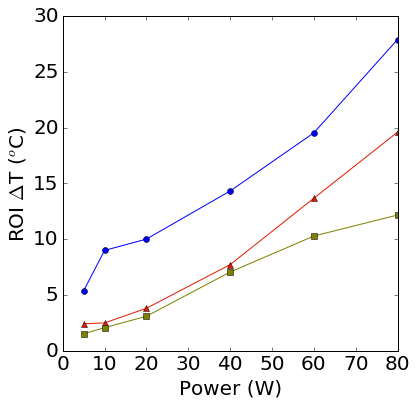

In [96]:
grouped = merged.query("material=='phantom'").query("power>=5").groupby(['tag','material'])
#computed = grouped['finalT'].agg([np.min, np.max])

fig=plt.figure(figsize=(6,6))

caseXadj=dict(single=-2.5,multi_1=0,multi_2=2.5)

ax = fig.gca()
for gidx,rowids in grouped:
    
    case=gidx[0]
    g=grouped.get_group(gidx).groupby('power')
    
    powers = list(g.groups.keys())  

    q5=g['Q5'].agg([np.mean])
    q25=g['Q25'].agg([np.mean])
    q50=g['Q95'].agg([np.mean])

    #q90=g['Q100'].agg([np.mean])
    plt.plot(q5.index , q50['mean'], 'o-',**plt_attr[case])
    

    plt.xlabel('Power (W)',fontsize=20)
    plt.ylabel('ROI $\Delta$T ($^o$C)',fontsize=20)
    ax.tick_params(labelsize=20)

In [98]:
tempQs[['Q5','Q95']]

,Q5,Q95
,mean,mean
power,,
5,0.059750,5.376855
10,0.185200,8.993842
20,0.425100,10.010765
40,0.504285,14.316667
60,1.176102,19.525622
80,0.901853,27.885665


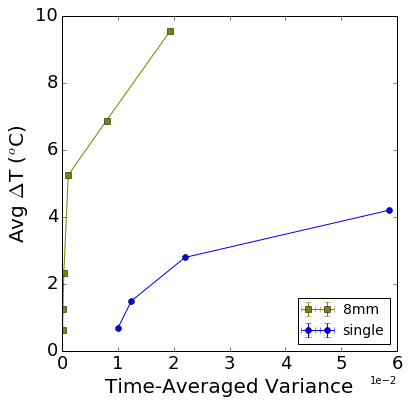

In [129]:
material="pork"
grouped = merged.query("material=='%s'"%material).query("power>=5").query("tag!='multi_x'").groupby(['tag','material'])
#computed = grouped['finalT'].agg([np.min, np.max])

fig=plt.figure(figsize=(6,6))

caseXadj=dict(single=-2.5,multi_1=0,multi_2=2.5)

ai=range(0,21)

ax = fig.gca()
for gidx,rowids in grouped:
    
    case=gidx[0]
    g=grouped.get_group(gidx).groupby('power')
    
    powers = list(g.groups.keys())  

    tempQs = g[['Q5','Q25', 'Q50','Q75', 'Q95', 'Q99', 'Q100']].agg([np.mean, np.max, np.min, np.std])
    avgTr = g['finalT'].agg([np.mean, np.max, np.std])
    stdTr = g['stdT'].agg([np.mean])
    cavVsPowerStatistic=[]
    
    for powi in range(len(powers)):
        power=powers[powi]
        res=imageLevelDF.query("material=='%s'"%material).query("case=='%s'"%case).query("power==%d"%powers[powi])
        res=specinfoDF.query("case=='%s'"%(case)).query("power==%d"%power).query("material=='%s'"%material)
        if len(res)==0:
            continue
            
        #curve_set_w_replicates = np.array(list(map(vectorizeAndNormalize, res.curve)))
        curve_set_w_replicates = np.array(list(map(lambda x: vectorstr2arr(x)[ai], res['Variance'])))/1e9
            
        time_integrated= np.mean(curve_set_w_replicates,axis=1)
        
        low=np.min(time_integrated)
        hi=np.max(time_integrated)
        avg=np.mean(time_integrated)
        
        cavVsPowerStatistic.append(dict(nsets=len(curve_set_w_replicates),power=powers[powi], avg=avg,low=low,hi=hi ))
    
        #cavitationSet=res[['power','Q0','Q5','Q25','Q50','Q75','Q95','Q100','mean','std']].mean()
        
        #cavVsPowerStatistic.append(cavitationSet)
    
    cavDf=pandas.DataFrame(cavVsPowerStatistic).sort_values('power')
    
    #tempVals=tempQs['Q50']['mean']
    yerr=avgTr['std'].as_matrix()/2
    tempVals=avgTr['mean'].as_matrix()
    
    #tempVals=tempQs['Q99']['amin'].as_matrix()
    #yerr=tempQs['Q99']['std'].as_matrix()/2
    #yerr=tempQs['Q99'][['amin','amax']].as_matrix().transpose()
    #yerr=[tempVals-yerr[0], yerr[1]-tempVals]
    #yerr=0
    #yerr=(tempQs[['Q5','Q95']].as_matrix()- tempVals).transpose() 


    #xvals=cavDf['Q50'].as_matrix()
    #xerr=cavDf['std'].as_matrix()/2.0 
    #xerr=(cavDf[['Q25','Q75']].as_matrix().transpose() - xvals)
    
    xvals=cavDf['avg'].as_matrix()
    xerr=cavDf[['low','hi']].as_matrix().transpose() 
    xerr=[xvals-xerr[0], xerr[1]-xvals]
    #xerr[0]*=-1
    #yerr[0]*=-1
    ax.errorbar(xvals, tempVals, xerr=xerr, yerr=yerr, label=plt_label[case]['label'],  **plt_attr[case])
    #meancav=cav['imgmag'].agg([np.mean])['mean']
    #ax.plot( avgTr['mean'], meancav /1e12 ,'-o', **plt_attr[case])
    
    
    #makeFullBoxPlot(ax, [q5['mean'],q25['mean'],q50['mean'],q75['mean'],q95['mean']],
    #                width=5, xargs=cavDf['mean'],
    #               plotkeys=dict(color='k'), boxkeys=dict(edgecolor='k',facecolor=plt_attr[case]['color']))
    

#ax.set_xscale('log')
#ax.set_yscale('log')

scf=mtick.ScalarFormatter(useOffset=None)
scf.set_powerlimits((-2,2))
ax.xaxis.set_major_formatter(scf)
#y_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
#ax.yaxis.set_major_formatter(y_formatter)
ax.set_xlabel('Time-Averaged Variance',fontsize=20)
ax.set_ylabel('Avg $\Delta$T ($^o$C)',fontsize=20)
ax.tick_params(labelsize=18)
plt.legend(fontsize=14,loc=4)

#ax.set_xlim([0, ax.get_xlim()[1]])
#ax.set_xlim([-100, 1200])

In [127]:
5*30/(3700*1000)

4.054054054054054e-05

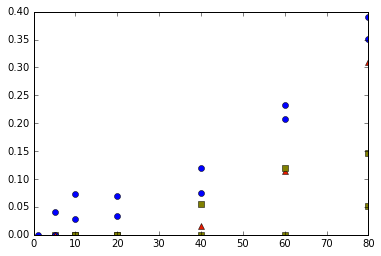

In [143]:
samp=merged.query("material=='phantom'")
for rowi in range(len(samp)):
    row = samp.iloc[rowi]
    plt.plot( row['power'], row['n10'] / row['nvox'], '-o', **plt_attr[row['tag']])

In [1374]:
samp=merged.query("material=='phantom'")
gg=merged[['power','tag','mild','material','mildfrac','nvox']].sort_values('power').groupby(['material','tag','power'])
res=gg.agg([np.mean, np.max, np.min])
res['mildfrac']

mean      amax      amin
material tag     power                              
phantom  multi_1 5      0.000000  0.000000  0.000000
                 10     0.000000  0.000000  0.000000
                 20     0.046875  0.046875  0.046875
                 40     0.197917  0.197917  0.197917
                 60     0.283854  0.283854  0.283854
                 80     0.276042  0.276042  0.276042
         multi_2 5      0.000000  0.000000  0.000000
                 10     0.001000  0.002000  0.000000
                 20     0.035000  0.070000  0.000000
                 40     0.149344  0.244000  0.054688
                 60     0.296510  0.330000  0.263021
                 80     0.530333  0.666667  0.394000
         single  1      0.028000  0.028000  0.028000
                 5      0.035000  0.070000  0.000000
                 10     0.095667  0.108000  0.083333
                 20     0.151125  0.156250  0.146000
                 40     0.248375  0.278000  0.218750
                 60     0.252927  0.283854  0.222000
                 80     0.242115  0.268229  0.216000
pork     multi_2 5      0.000000  0.000000  0.000000
                 10     0.006667  0.006667  0.006667
                 20     0.208333  0.208333  0.208333
                 40     0.295000  0.295000  0.295000
                 60     0.321667  0.321667  0.321667
                 80     0.270000  0.270000  0.270000
         single  5      0.023333  0.023333  0.023333
                 10     0.080000  0.080000  0.080000
                 20     0.120000  0.120000  0.120000
                 40     0.158333  0.158333  0.158333

In [1369]:
res.to_csv("/Users/Vandiver/OneDrive/Documents/Multi-foc Paper/NumVoxelsMild4-8.csv")

In [36]:
merged.keys()

Index(['Unnamed: 0', 'baselineDyns', 'date', 'fi', 'file', 'roi', 'scan',
       'unwrapped', 'avgT', 'finalT', 'maxT', 'maxTdata', 'momR', 'momX',
       'momY', 'momZ', 'n10', 'n15', 'n5', 't', 'power', 'nfoc', 'tag',
       'material', 'stdT', 'peakT', 'mild', 'nvox', 'mildfrac', 'Q0', 'Q5',
       'Q10', 'Q25', 'Q50', 'Q75', 'Q90', 'Q95', 'Q99', 'Q100'],
      dtype='object')